# Homogeneous pairs model


In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../pairedRS')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sys

In [45]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

## Note
In all the implementations, we will assume row represents the users and column represents the movies. This is a nontrivial asumption that will affect the sampling process.

In [46]:
n1, n2 = 310, 300
r = 8
prob_obs = 0.2
random_state = 20

In [47]:
sampler = PairSampling(n1,n2)
size_obs = n1 * n2 * prob_obs
n_calib_pairs = int(size_obs//4)

In [48]:
mask_obs = sampler.sample_submask(size_obs, random_state=random_state)
mask_test = np.ones_like(mask_obs) - mask_obs

In [52]:
mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs,
                                                                           random_state=random_state)

In [53]:
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

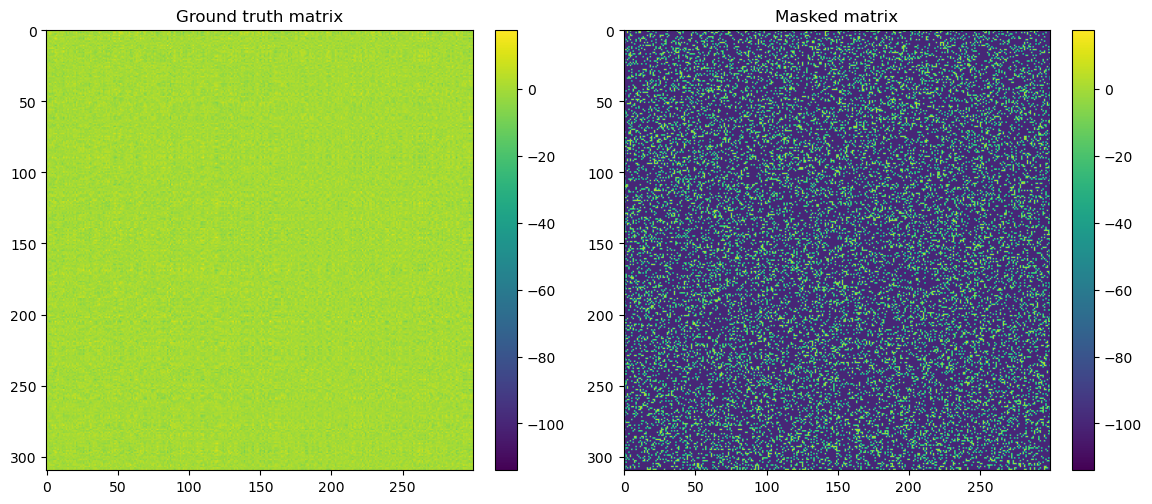

Observation size: 18600.0, training size: 9300.0, calib size: 9300.0, calib pairs: 4650


In [54]:
assert np.all(mask_train+mask_calib==mask_obs),'Sampling error!'
vmin, vmax = np.min(M)-100, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}, calib pairs: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), n_calib_pairs))

In [55]:
print("Weighted sampling\n"+"-"*25)
print('Solving matrix completion with PMF...')
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r, random_state=random_state, verbose=True)
test_mse = evaluate_mse(M, Mhat, mask_test)
train_mse = evaluate_mse(M, Mhat, mask_train)
calib_mse = evaluate_mse(M, Mhat, mask_calib)
print('train MSE: {}, calib MSE: {}, test MSE: {}'
      .format(train_mse, calib_mse, test_mse))

Weighted sampling
-------------------------
Solving matrix completion with PMF...
Iteration: 1; Mean diff: 0.0004
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Stopping criteria met, training terminated.
train MSE: 2.6584611359759384e-06, calib MSE: 0.023856599148724695, test MSE: 0.014899992226037957


In [59]:
# Sample test pairs
n_test_pairs = min(int((np.sum(mask_test)-n1)//2), 1000)
_, idxs_test, _, _ = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)

In [60]:
alpha = 0.1
cpi = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)

In [61]:
cpi_lower, cpi_upper, is_inf, weights = cpi.get_CI(idxs_test, alpha)

Computing prediction intervals for 1000 test pairs...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.65it/s]

Done!


In [62]:
naive_lower, naive_upper = cpi.naive_CI(idxs_test, alpha)

Computing naive prediction intervals for 1000 test pairs...
Done!


In [63]:
bm_lower, bm_upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha)

Computing prediction intervals for 1000 test pairs...
Done!


In [64]:
evaluate_pairedCI(naive_lower, naive_upper, M, idxs_test, method="Naive" )

,Pair_coverage,Coverage,Size,Method
0,0.908,0.9455,0.021978,Naive


In [65]:
evaluate_pairedCI(cpi_lower, cpi_upper, M, idxs_test, method="CPI" )

,Pair_coverage,Coverage,Size,Method
0,0.902,0.942,0.021112,CPI


In [66]:
evaluate_pairedCI(bm_lower, bm_upper, M, idxs_test, method="Benchmark" )

,Pair_coverage,Coverage,Size,Method
0,0.94,0.964,0.0275,Benchmark
